<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/staging/SCM290-GreenVehicleRoutingProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ortools
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Week 3 Green Location Problem
FastShipCo has has to deliver 20 locations with various demand level and truck constraints. 5 possible locations have been identified for building distribution centers. Only up to 2 DC can be opened. 
Find the best location for the 2 DCs while optimizing total cost including CO2 emissions

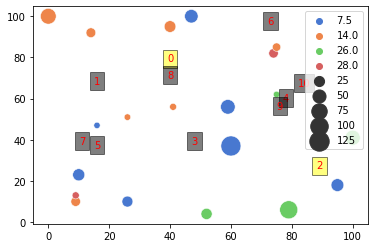

Objective= 160015.40056820348
TotalTransportationCost 30817.96688274649
TotalCarbonEmission 1291.9743368545699
IsDCOpened=
 ['DC0=1' 'DC1=0' 'DC2=1' 'DC3=0' 'DC4=0' 'DC5=0' 'DC6=0' 'DC7=0' 'DC8=0'
 'DC9=0' 'DC10=0']
DoesDCServeNode=
 [['DC0->Node0=0' 'DC0->Node1=1' 'DC0->Node2=0' 'DC0->Node3=1'
  'DC0->Node4=0' 'DC0->Node5=1' 'DC0->Node6=0' 'DC0->Node7=1'
  'DC0->Node8=0' 'DC0->Node9=1' 'DC0->Node10=1' 'DC0->Node11=1'
  'DC0->Node12=1' 'DC0->Node13=1' 'DC0->Node14=1' 'DC0->Node15=1'
  'DC0->Node16=0' 'DC0->Node17=1' 'DC0->Node18=0' 'DC0->Node19=1']
 ['DC1->Node0=0' 'DC1->Node1=0' 'DC1->Node2=0' 'DC1->Node3=0'
  'DC1->Node4=0' 'DC1->Node5=0' 'DC1->Node6=0' 'DC1->Node7=0'
  'DC1->Node8=0' 'DC1->Node9=0' 'DC1->Node10=0' 'DC1->Node11=0'
  'DC1->Node12=0' 'DC1->Node13=0' 'DC1->Node14=0' 'DC1->Node15=0'
  'DC1->Node16=0' 'DC1->Node17=0' 'DC1->Node18=0' 'DC1->Node19=0']
 ['DC2->Node0=1' 'DC2->Node1=0' 'DC2->Node2=1' 'DC2->Node3=0'
  'DC2->Node4=1' 'DC2->Node5=0' 'DC2->Node6=1' 'DC2->Node7=0'


In [ ]:
from ortools.sat.python import cp_model
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

INFINITY = cp_model.INT32_MAX
model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_resultarray=np.vectorize(lambda v:solver.Value(v))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

#-- INPUTS
MaxOpenedDCs=2

#[X, Y, Demand, TruckSize]
DemandNodes= np.array([
  [79, 6, 107,  26],
  [16, 47, 2,  7.5],
  [60, 37, 134,  7.5],
  [14, 92, 22,  14],
  [100, 41, 71,  26],
  [9, 10, 21,  14],
  [75, 62, 3,  26],
  [59, 56, 65,  7.5],
  [26, 10, 31,  7.5],
  [10, 23, 41,  7.5],
  [26, 51, 3,  14],
  [41, 56, 5,  14],
  [40, 95, 37,  14],
  [0, 100, 78,  14],
  [47, 100, 54,  7.5],
  [9, 13, 6,  28],
  [95, 18, 47,  7.5],
  [74, 82, 20,  28],
  [52, 4, 33,  26],
  [75, 85, 13,  14]
])

#[X, Y]
CandidateDCs= np.array([
  [39, 78],
  [15, 67],
  [88, 26],
  [47, 38],
  [77, 59],
  [15, 36],
  [72, 96],
  [10, 38],
  [39, 70],
  [75, 55],
  [82, 66],
])




#Fuel Comsumption : [Truck Size, FCEmpty in Liter/km, FCFull in Liter/Km]
FC= np.array([
    [7.5, 0.11, 0.134],
    [14, 0.171, 0.228], 
    [26, 0.244, 0.352], 
    [28, 0.255, 0.402]
])

#Shape:CandidateDCs x DemandNodes 
EuclidianDistances=np.array(list(list(math.sqrt((dc[0]-node[0])**2+(dc[1]-node[1])**2) for node in DemandNodes) for dc in CandidateDCs))

#Shape:DemandNodes
FCEmptyForNode=np.array(list(FC[FC[:,0]==truckSize,1][0] for truckSize in DemandNodes[:,3]))
FCFullForNode=np.array(list(FC[FC[:,0]==truckSize,2][0] for truckSize in DemandNodes[:,3]))
LoadFactorForNode=np.array(list(node[2]/node[3] for node in DemandNodes))
CeiledLoadFactorForNode=np.ceil(LoadFactorForNode)
CarbonEmissionFactor=2.6 #Kg of CO2 / Liter
CostPerTonKilometer=1.20 #$ / Ton.km

#- DECISIONS VARIABLES
#Shape : CandidateDCs
IsDCOpened=np.asarray(list(model.NewBoolVar("DC{}".format(dc)) for dc in range(CandidateDCs.shape[0])))
#Shape : DemandNodes x CandidateDCs 
DoesDCServeNode=np.asarray(list(list(model.NewBoolVar("DC{}->Node{}".format(dc,node)) for node in range(DemandNodes.shape[0])) for dc in range(CandidateDCs.shape[0])) )

#-- CONSTRAINTS
# each node is served by at most 1 dc
add_constraints_eq(np.sum(DoesDCServeNode, axis=0), 1)
# max opened DCs
add_constraints_eq(np.sum(IsDCOpened), MaxOpenedDCs)
# a node is served if the dc is opened
for dc in range(CandidateDCs.shape[0]):
  add_constraints_le(DoesDCServeNode[dc,:], IsDCOpened[dc]) 

#-- OBJECTIVE FUNCTION
CostOfCarbon=100
TotalTransportationCost = CostPerTonKilometer*np.sum(np.sum(DemandNodes[:,2]*EuclidianDistances*DoesDCServeNode))
TotalCarbonEmission = CarbonEmissionFactor*np.sum(np.sum(EuclidianDistances*(FCEmptyForNode*CeiledLoadFactorForNode+(FCFullForNode-FCEmptyForNode)*LoadFactorForNode)*DoesDCServeNode))
TotalCost=TotalTransportationCost+CostOfCarbon*TotalCarbonEmission
model.Minimize(TotalCost)

#-- EXECUTION
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status == cp_model.OPTIMAL:
    fig, ax = plt.subplots()
    sns.scatterplot(data=DemandNodes, x=DemandNodes[:,0], y=DemandNodes[:,1], size=DemandNodes[:,2], hue=DemandNodes[:,3],sizes=(40, 400), palette="muted", ax=ax)

    for i in range(CandidateDCs.shape[0]):
      ax.text(x=CandidateDCs[i,0],y=CandidateDCs[i,1],s=i, fontdict=dict(color='red',size=10), bbox=dict(facecolor='yellow' if solver.Value(IsDCOpened[i])==1 else 'black',alpha=0.5))

    plt.show()

    print("Objective=", solver.ObjectiveValue())
    print("TotalTransportationCost", solver.Value(TotalTransportationCost) )
    print("TotalCarbonEmission", solver.Value(TotalCarbonEmission) )
    print("IsDCOpened=\n", vararray_to_results(IsDCOpened))
    print("DoesDCServeNode=\n", vararray_to_results(DoesDCServeNode))
else:
    print('No optimal solution found.')


In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
import numpy as np
import math

# For MEdium Truck
#    W = 5500    # kg, Curb weight (Medium Duty Truck)
#    L = 12500   # kg, Maximum Load
#    k = 0.20    # kJ/rev/L, Engine friction factor
#    N = 36.67   # rps, Engine speed
#    V = 6.9     # L, Engine displacement 
#    Cd = 0.7    # Coefficient of aerodynamics drag
#    A =  8.0    # m^2, Frontal Surface Areal
# For Heavy Truck
CurbWeight = 6350    # kg, Curb weight (Medium Duty Truck)
L = 28000   # kg, Maximum Load
k = 0.20    # kJ/rev/L, Engine friction factor
N = 33      # rps, Engine speed
V = 5       # L, Engine displacement 
Cd = 0.7   # Coefficient of aerodynamics drag
A =  3.912    # m^2, Frontal Surface Areal

Xi = 1      # Fuel to Air Mass Ratio
g = 9.81    # m/s^2, Gravitational Constant 
Ro = 1.2041 # kg/m^3, Air Density 
Cr = 0.01   # Coefficient of rolling resistance
Eta = 0.45  # Efficiency parameter for diesel engines
Eta_tf = 0.45 # Vehicule drivetrain efficiency
Kappa = 44  # kJ/g, Heating value of a typical diesel fuel
Psi = 737   # Conversion factor (g/s to L/s)
Beta = Cd*Ro*A/2

Gamma = 1/(1000*Eta*Eta_tf)
Lambda = Xi/(Kappa*Psi)
FuelToCO2=2.65 # kg/l

# REmarks : formula mix between Heavy Truck and Medium Truck
#   - Heavy Truck for k, N, V
#   - MEdium Truck for W (curb weight)
# why speed / 3.6 ?
CurbWeight = 5500    

# acceleration(m/s), distance(km), angle(degrees), load (kg), (m/s)
def FuelConsumption(acceleration, distance, slope, total_weight, v):
  v=v/3.6  #magic speed conversion to match exercise ???
  if (slope >= 0): #Topography model
    degree=slope*0.57
    theta=degree*math.pi/180 # radian
    Alpha=acceleration+g*math.sin(theta)+g*Cr*math.cos(theta)
    return Lambda*distance/v*(k*N*V+Gamma*(total_weight*Alpha*v)+Beta*Gamma*v**3)
  else: #Planar Model
    return Lambda*distance/v*(k*N*V)


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix_meter'] = np.array([
        [ 0, 10.1, 15.6, 12.4, 10.1, 10.2, 13.9, 10.5, 5, 5.3, 2.1, 11.3, 18.7, 5, 2.2, 16.7, 14.5, 9.2, 14.4, 8.4, 13.4, 10.2, 13.3, 15.6, 7.3, 4.1, 8.8, 13.4, 3, 15.7, 11.8 ],
        [ 9.6, 0, 9.2, 9.3, 0.85, 2.9, 4.3, 10, 9.2, 10.1, 9.1, 5.2, 10.7, 9.8, 8.8, 8, 12.4, 2.4, 5.9, 6.1, 4.2, 2.6, 8.8, 9.9, 7.8, 8.2, 6.5, 4.9, 8.8, 7.2, 6.1 ],
        [ 15.7, 9.1, 0, 2.5, 10, 11.7, 10.4, 2.9, 13.8, 9.3, 13.7, 4.3, 2.1, 8.8, 13.4, 7.6, 5, 9, 6.8, 6.3, 11.6, 5.1, 1.3, 1.3, 6.3, 9.1, 5.6, 7, 14.5, 6.3, 3.4 ],
        [ 13.3, 9.1, 2.4, 0, 10.1, 11.8, 10.6, 1, 11.5, 7, 11.4, 4.1, 4.4, 6.5, 11.1, 8.6, 4.4, 9, 7.3, 4, 11.8, 2.8, 1, 1.8, 4, 6.8, 4.3, 7.1, 8.7, 7.3, 3.5 ],
        [ 10, 0.85, 9.9, 9.9, 0, 2.8, 4.9, 10.5, 9.6, 10.6, 9.5, 5.9, 11.4, 10.2, 9.2, 8.7, 13.1, 1.1, 6.6, 6.5, 5.3, 9.2, 9.5, 10.5, 8.3, 8.6, 6.9, 5.6, 9.2, 7.9, 8.3 ],
        [ 9.3, 3.2, 12.4, 11.1, 3.2, 0, 6, 11.5, 8.8, 11.6, 8.7, 8.4, 13.9, 11.3, 8.5, 11.2, 15.6, 5.2, 9.1, 7.5, 5.6, 10.1, 12, 13, 9.2, 9, 7.9, 8.1, 10.2, 10.4, 9.2 ],
        [ 13.3, 4.1, 10.6, 11.1, 5, 6.6, 0, 13.1, 12.9, 13.9, 12.8, 6.6, 10.9, 13.5, 12.5, 6.3, 13.8, 5.4, 4.2, 9.6, 1.1, 11.8, 10.4, 11.3, 11.5, 11.9, 8.8, 4, 12.5, 5.5, 7.9 ],
        [ 12, 10.2, 2.9, 1, 10.4, 12.1, 11.6, 0, 11.9, 6.3, 11.8, 5.1, 4.8, 5.5, 11.5, 9.4, 4.1, 9.4, 8.3, 4.4, 12.8, 3.2, 2, 2.2, 3.7, 7.2, 4.7, 8.1, 8, 8.1, 4.5 ],
        [ 4.4, 9.2, 13.4, 11.5, 9.2, 10.4, 13, 11.9, 0, 8.6, 2.4, 10.1, 15.6, 8.3, 2.4, 15.8, 17.5, 8.7, 13.6, 8.4, 12.6, 10.5, 12.5, 13.5, 9.3, 6, 8.3, 12.5, 7.2, 14.8, 10.9 ],
        [ 6.3, 11.9, 10.5, 7.2, 11.9, 13.1, 14.5, 6.2, 8.7, 0, 6.8, 9.6, 11, 0.75, 6.6, 15.6, 8.6, 11.4, 13.8, 5.4, 14, 5, 8.5, 8.2, 3.1, 3.1, 5.8, 12.1, 2.9, 14.9, 10.5 ],
        [ 2.1, 10, 12.9, 11, 10, 11.3, 13.8, 11.4, 2.4, 6.6, 0, 9.6, 15.1, 6.3, 0.21, 15.5, 15.8, 9.5, 13.3, 7.4, 13.4, 10, 12, 13, 8.6, 5.4, 8.2, 12.2, 4.3, 14.5, 10.4 ],
        [ 11.6, 5.2, 4.4, 3.9, 6.1, 7.8, 6.3, 4.4, 11.2, 9.3, 11.1, 0, 5.6, 8.7, 10.8, 5.9, 7.7, 4.8, 3.8, 4.7, 7.4, 5.1, 4.1, 5.1, 6.3, 9.7, 4, 2.7, 10.3, 4.9, 1.3 ],
        [ 17.3, 10.5, 2.2, 4.4, 11.4, 13.2, 10.8, 4.8, 15.1, 11.8, 19.2, 5.3, 0, 10.8, 14.7, 8.1, 6.9, 10.3, 7.2, 8.3, 12, 6.9, 3.3, 3, 8, 11.1, 7.6, 8, 15.4, 6.8, 4.5 ],
        [ 5.9, 11.6, 9, 6.5, 11.6, 12.8, 13.6, 5.7, 8.3, 0.75, 6.4, 8.7, 11.1, 0, 6.2, 14.6, 10.3, 11, 12.3, 4.7, 13.1, 3.8, 7.5, 8.1, 2.4, 2.7, 5.2, 11.2, 2.5, 13.4, 9.8 ],
        [ 2.1, 10, 12.8, 11, 9.9, 11.2, 13.7, 11.3, 3.2, 6.6, 0.21, 9.5, 15.1, 6.2, 0, 15.4, 15.8, 8, 13.2, 7.3, 13.3, 10, 11.9, 12.9, 8.5, 5.3, 7.7, 12.1, 4.2, 14.4, 10.4 ],
        [ 16.3, 7.8, 7.5, 8.5, 9, 10.7, 6.4, 9.4, 15.8, 15, 15.7, 6.1, 8.2, 14.4, 15.4, 0, 11.5, 9.5, 2.4, 10.4, 7.6, 10.8, 7.7, 8.4, 12, 14.3, 9.7, 3.9, 14.9, 1.3, 6.5 ],
        [ 13.3, 10.9, 3.9, 3, 11.8, 13.6, 12.5, 2.8, 17.3, 9.2, 14.9, 6.1, 5.6, 6.9, 14.6, 10.2, 0, 10.8, 9, 7.6, 13.8, 5.2, 2.8, 2.4, 5.1, 9.8, 7.6, 8.8, 9.6, 8.9, 5.3 ],
        [ 10.5, 2.6, 8.9, 9, 1.1, 3.8, 6.1, 9.7, 9.2, 11, 9.1, 4.9, 10.5, 10.6, 8.8, 9.9, 12.1, 0, 7.4, 6.2, 5.9, 8.3, 8.5, 9.6, 7.9, 8.1, 6.4, 6.4, 9.7, 8.9, 5.8 ],
        [ 14, 5.7, 6.7, 7.2, 6.6, 8.3, 4.1, 8.1, 13.5, 12.8, 13.4, 3.8, 7.3, 12.2, 13.1, 2.3, 10.4, 7.3, 0, 8.2, 5.3, 8.6, 6.8, 7.6, 9.7, 12, 7.4, 1.7, 12.6, 1.4, 3.6 ],
        [ 8.7, 6.4, 5.9, 3.6, 7.3, 9, 8.6, 4, 8.2, 6.2, 8.2, 4.2, 7.3, 6, 7.9, 10.1, 8.2, 6.3, 7.9, 0, 9.2, 2.6, 4.6, 5.5, 2.8, 4.7, 0.65, 6.8, 6, 9.1, 4.6 ],
        [ 12.8, 4.2, 11.7, 11.9, 4.8, 6.1, 1.1, 12.6, 12.4, 13.4, 12.3, 7.7, 12.1, 13, 12, 7.4, 15, 6, 5.3, 9.1, 0, 11.3, 11.5, 12.4, 11.6, 11.4, 9.4, 5.1, 13.3, 6.6, 8.7 ],
        [ 9.5, 8.2, 5.3, 2.8, 9.1, 10.8, 10.3, 3.2, 10.6, 4.4, 10, 4.8, 7.4, 3.8, 9.8, 10.7, 6.1, 8.1, 8.7, 3.1, 11, 0, 3.8, 4.6, 1.2, 4.9, 3.4, 7.5, 6.1, 9.7, 5.3 ],
        [ 14.3, 8.4, 1.4, 1, 9.3, 11.1, 9.9, 2.1, 12.4, 7.9, 12.3, 3.6, 3.6, 7.4, 12, 8, 4.2, 8.3, 6.5, 4.9, 11.3, 3.7, 0, 1.2, 4.9, 7.7, 4.9, 6.3, 8.7, 6.7, 2.8 ],
        [ 14.1, 9.8, 1.3, 1.8, 10.6, 12.4, 11.3, 2.1, 13.6, 8.2, 13.5, 5, 3.2, 7.6, 13.2, 8.4, 2.4, 9.6, 7.5, 6.1, 12.6, 4.7, 1.2, 0, 5.9, 8.9, 6.4, 7.6, 11.8, 7.1, 4.1 ],
        [ 8.6, 8.6, 6.5, 4, 9.5, 11.3, 11.9, 3.7, 9.3, 3.1, 11.2, 6, 8.5, 2.5, 9, 11.9, 6.4, 8.5, 9.8, 3, 11.5, 1.3, 4.9, 6, 0, 3.8, 3.5, 8.7, 4.8, 10.9, 6.5 ],
        [ 4.9, 9.3, 9.5, 7, 9.3, 10.5, 13, 7.3, 6, 3.1, 5.4, 8.5, 11.5, 2.7, 5.2, 14.4, 11.9, 8.7, 12.1, 4.5, 12.6, 5, 7.9, 9, 3.8, 0, 4.9, 11, 1, 13, 9 ],
        [ 8.7, 6, 5.5, 4.6, 6.9, 8.6, 9.3, 5, 8.3, 5.7, 8.2, 3.9, 6.9, 5.9, 7.9, 9.8, 8.7, 5.9, 7.6, 0.65, 8.8, 3.4, 5.1, 6.2, 3.1, 4.8, 0, 6.4, 6.1, 8.7, 4.2 ],
        [ 12.8, 4.9, 7.5, 7.8, 5.8, 7.6, 3.4, 8.1, 12.4, 11.6, 12.3, 3.8, 8.2, 11, 12, 3.8, 11.1, 5.9, 1.4, 7, 4.5, 7.4, 7.5, 8.4, 8.5, 10.9, 6.3, 0, 12.1, 2.7, 4.2 ],
        [ 3.5, 10.6, 10.3, 7.8, 10.6, 10.7, 14, 8, 6.7, 2.8, 4.4, 9.1, 13.1, 2.5, 4.2, 15, 11.7, 10, 12.8, 5.3, 13.6, 6.3, 8.8, 12.1, 4.7, 1, 5.8, 11.6, 0, 14, 9.9 ],
        [ 15, 7.1, 6.2, 7.2, 8, 9.7, 5.5, 8.1, 14.5, 13.7, 14.4, 5.3, 6.9, 13.1, 14.1, 1.3, 10.2, 8.3, 1.3, 9.1, 6.6, 9.5, 6.4, 7.1, 10.7, 13, 8.4, 2.7, 13.6, 0, 5 ],
        [ 11.3, 5.8, 3.4, 3.4, 6.7, 8.5, 7.4, 4.2, 10.8, 9.5, 10.7, 1, 4.5, 8.9, 10.5, 6.5, 6.6, 5.7, 3.6, 4.9, 8.5, 5.3, 3, 4, 6.4, 9.2, 4.2, 3.8, 9.9, 4.9, 0 ],
   ])
    
    data['slope_matrix_gradient']= np.array([
        [ 0, 0, -0.1, -0.1, -0.05, -0.1, 0, -0.05, -0.05, 0.05, -0.45, 0, -0.05, 0.05, -0.45, 0.15, -0.55, -0.1, 0.05, 0.3, 0.1, 0.05, -0.05, -0.05, -0.1, -0.05, 0.2, 0.05, 0.05, 0.05, 0.05 ],
        [ -0.1, 0, 0.05, 0.2, -0.35, -0.15, -0.15, 0.2, 0, 0.15, -0.1, 0.05, 0.1, 0.15, -0.1, 0.25, 0.1, -0.4, 0.05, 0.35, 0.1, 0.35, 0.2, 0.2, 0.15, 0.1, 0.25, 0.05, -0.05, 0.1, 0.1 ],
        [ -0.05, -0.05, 0, 0.3, -0.1, -0.05, -0.15, -0.1, -0.05, -0.05, -0.1, -0.2, -0.35, -0.1, -0.05, 0.4, 0.05, -0.1, 0.05, -0.45, 0, -0.1, 0.45, 0.5, -0.4, -0.2, 0.3, 0, -0.05, 0.15, -0.2 ],
        [ 0, -0.15, -0.6, 0, -0.1, -0.15, -0.2, 0.15, 0, 0, -0.05, -0.3, -0.5, 0, -0.05, 0.2, -0.15, -0.2, -0.25, -0.4, -0.05, 0.15, -0.15, -0.35, -0.3, 0, 0.3, 0, 0.05, 0, -0.25 ],
        [ -0.05, 0.35, 0.1, 0.15, 0, -0.05, -0.15, 0.1, -0.1, 0.1, -0.1, 0, -0.1, 0.1, -0.1, -0.2, -0.1, -0.3, 0.05, 0.3, 0.05, 0.25, 0.15, 0.15, 0.05, 0.05, 0.2, 0, -0.05, 0.05, 0.1 ],
        [ 0, 0.05, 0.05, 0.15, -0.1, 0, 0.05, 0.1, 0, 0.05, -0.05, 0, -0.1, 0.1, 0.05, 0.2, 0, -0.15, 0.05, 0.3, -0.15, 0.25, 0.25, 0.15, 0.05, 0, 0.25, -0.05, 0.05, 0.05, 0.05 ],
        [ -0.1, -0.05, 0.05, 0.1, 0.1, -0.1, 0, 0.05, -0.05, 0.1, -0.1, -0.1, -0.3, 0.1, -0.1, 0, 0.1, -0.25, -0.1, 0.25, 0.05, 0.15, 0.1, 0.1, 0.15, 0, 0.15, -0.2, 0, 0.05, 0 ],
        [ -0.05, -0.15, -0.65, -0.15, -0.1, -0.15, -0.4, 0, 0, 0.1, -0.1, -0.2, -0.25, 0.05, -0.1, 0.05, -0.05, -0.15, -0.25, -0.3, -0.15, 0.3, -0.45, -0.1, 0.15, -0.05, 0.4, 0.05, 0.1, -0.1, -0.15 ],
        [ 0.1, 0, -0.1, 0, -0.05, -0.1, -0.05, -0.05, 0, 0, -0.2, -0.05, -0.05, 0, -0.15, 0.2, 0, -0.1, 0, 0.3, 0.05, 0.15, 0.1, 0, -0.05, -0.1, 0.2, -0.05, 0, 0.05, 0.05 ],
        [ -0.15, -0.05, 0.25, 0.15, -0.05, -0.1, -0.2, -0.15, -0.05, 0, -0.2, 0.3, -0.05, -0.5, -0.2, 0.25, -0.05, -0.2, 0.25, -0.15, -0.05, 0.3, 0.35, -0.05, -0.25, -0.45, -0.2, 0.45, -0.2, 0.25, 0.25 ],
        [ 0.25, 0, -0.05, 0.05, -0.05, -0.1, -0.05, 0, 0.05, 0.05, 0, -0.05, -0.1, 0, -0.3, 0.15, 0, -0.05, 0.05, 0.35, 0.05, 0.05, -0.05, 0, -0.05, -0.1, 0.25, -0.05, 0, 0.05, 0.05 ],
        [ 0, 0.2, 0, 0.25, 0.15, 0.05, 0.2, 0.25, 0.1, -0.15, 0.05, 0, -0.25, -0.2, 0.1, 0.45, 0.1, 0, 0.15, 0.6, 0.2, 0.35, 0.3, 0.25, -0.1, 0.15, 0.45, 0.5, 0.05, 0.2, 0.2 ],
        [ 0, 0.1, 0.1, 0.25, 0.15, 0.1, 0.2, 0.05, 0.05, -0.1, -0.05, 0.05, 0, -0.1, -0.05, 0.5, -0.05, -0.35, 0.2, -0.3, 0.2, 0.05, 0.3, 0.25, -0.25, -0.1, 0.2, 0.15, -0.05, 0.35, 0.2 ],
        [ -0.1, 0.05, 0.3, 0.1, -0.05, -0.1, -0.25, -0.1, -0.05, 0, -0.2, 0.35, -0.05, 0, -0.1, 0.25, -0.05, -0.3, -0.05, 0, -0.1, -0.4, 0.4, -0.05, -0.6, -0.35, -0.05, -0.15, 0, 0.25, 0.2 ],
        [ 0.25, -0.05, -0.05, 0, -0.05, -0.1, -0.05, 0, 0, 0.05, -0.45, -0.05, -0.05, 0.05, 0, 0.15, 0, -0.05, 0, 0.35, 0.05, 0.05, 0, 0, -0.05, -0.1, 0.25, -0.05, -0.05, 0.05, 0.05 ],
        [ -0.2, -0.25, -0.45, -0.35, -0.25, -0.25, 0.05, -0.3, -0.15, -0.2, -0.15, -0.35, -0.75, -0.2, -0.15, 0, 0.3, -0.35, 0, 0.05, 0.05, 0, -0.35, -0.4, -0.1, -0.1, -0.05, 0.1, -0.2, 1.45, -0.1 ],
        [ -0.05, -0.2, -0.55, -0.35, -0.2, -0.2, -0.25, -0.15, 0, -0.05, -0.1, -0.35, -0.35, -0.05, -0.1, 0.05, 0, -0.2, -0.3, 0, -0.15, -0.1, -0.35, -0.4, -0.25, -0.1, 0, -0.15, -0.05, -0.1, -0.2 ],
        [ -0.05, 0.35, 0.15, 0.3, 0.2, 0.05, 0, 0.25, 0, 0.15, -0.05, 0.15, -0.1, 0.2, 0, 0.25, 0.15, 0, 0, 0.55, 0.15, 0.4, 0.3, 0.25, 0.2, 0, 0.35, 0.1, 0, 0.1, 0.2 ],
        [ -0.05, 0, -0.2, 0.15, 0, -0.05, 0.05, 0.1, 0, -0.05, 0, -0.25, -0.45, -0.1, 0, -0.05, 0.05, -0.15, 0, 0.35, 0.05, 0.2, -0.05, -0.15, 0.3, 0.05, 0.25, -0.15, 0, -0.1, 0.05 ],
        [ -0.2, -0.3, -0.5, -4, -0.25, -0.3, -0.45, -0.55, -0.2, -0.55, -0.25, 0.05, -0.2, -0.6, -0.25, 0.15, -0.3, -0.45, -0.1, 0, -0.2, -0.35, 0, 0.05, 0.6, 0.1, -0.35, 0.2, 0.25, 0.05, -0.2 ],
        [ -0.15, -0.2, 0, 0.05, -0.15, -0.2, -0.4, 0.05, -0.1, 0.05, -0.15, -0.1, -0.35, 0.05, -0.35, -0.05, 0.05, -0.35, -0.25, 0.2, 0, 0.1, 0.05, 0.05, 0.1, -0.05, 0.1, -0.35, -0.05, -0.05, -0.05 ],
        [ -0.1, -0.15, 0, -0.25, -0.05, -0.15, -0.3, -0.3, -0.15, -0.35, -0.15, 0.25, -0.05, -0.45, -0.15, 0.15, -0.25, -0.3, 0, 0.05, -0.15, 0, 0.25, 0.15, -0.1, 0.45, 0, -0.1, -0.2, 0.05, 0 ],
        [ -0.05, -0.2, -0.7, 0, -0.15, -0.2, -0.25, -0.2, -0.05, -0.4, -0.1, -0.4, -0.5, -0.5, -0.05, 0.15, -0.15, -0.25, -0.3, -0.65, -0.1, -0.3, 0, -0.05, -0.65, -0.25, 0.05, -0.05, 0, 0, -0.35 ],
        [ -0.05, -0.15, -0.4, 0, -0.15, -0.15, -0.2, 0.1, 0, -0.1, -0.05, -0.35, -0.35, -0.05, -0.1, 0.25, -0.1, -0.2, -0.3, -0.7, -0.1, -0.3, -0.1, 0, -0.1, -0.1, -0.2, -0.1, 0, 0.05, -0.35 ],
        [ -0.05, -0.2, 0.45, 0.4, -0.1, -0.1, -0.4, -0.1, 0.05, 0.3, -0.15, 0.75, -0.05, 0.25, -0.15, 0.35, -0.2, -0.3, 0.3, -0.5, -0.15, 0.1, 0.8, 0.05, 0, 0.4, -0.3, 0.7, 0.25, 0.35, 0.35 ],
        [ 0.1, 0.05, -0.05, -0.45, 0.05, -0.05, -0.1, -0.05, 0.1, 0.3, -0.05, -0.15, -0.1, 0.3, 0, 0.1, 0, -0.2, -0.05, -0.05, 0, -0.55, -0.1, -0.05, 0.5, 0, -0.15, -0.1, -0.15, -0.05, 0 ],
        [ -0.2, -0.35, -0.4, -0.5, -0.3, -0.3, -0.5, -0.5, -0.2, 0.3, -0.25, 0.1, -0.2, 0.25, -0.2, 0.25, -0.25, -0.65, -0.4, 0.25, -0.25, -0.25, 0, 0.1, 0.15, 0.15, 0, -0.4, 0.15, 0.1, -0.1 ],
        [ -0.05, -0.1, 0.1, 0.15, -0.05, -0.1, -0.2, 0.1, 0.05, -0.15, 0, 0.15, -0.15, -0.15, 0.1, 0.1, 0.05, -0.1, 0.1, 0.4, 0, 0.25, 0.2, 0.15, 0, 0.1, 0.3, 0, 0.05, 0.4, 0.35 ],
        [ 0.05, 0, -0.15, -0.05, 0, -0.05, 0.05, -0.25, 0, 0.05, -0.05, 0, -0.1, -0.05, -0.05, 0.2, -0.1, -0.1, 0.05, 0.05, 0.1, 0.05, -0.1, -0.1, -0.3, -0.05, -0.05, 0, 0, 0.05, 0.05 ],
        [ -0.1, -0.1, -0.35, -0.15, -0.1, -0.1, -0.1, -0.15, -0.05, -0.2, -0.05, -0.2, -0.6, -0.15, -0.05, -1.45, 0.25, -0.25, 0.05, 0.25, 0, 0.1, -0.2, -0.25, -0.05, -0.05, 0.1, 0.05, -0.05, 0, -0.05 ],
        [ 0.05, -0.05, -0.05, 0.25, -0.1, -0.1, -0.15, 0.15, -0.05, -0.2, -0.1, -0.15, -0.35, -0.2, -0.05, 0.25, 0.05, -0.05, -0.2, 0.45, 0.05, 0.3, 0.3, 0.2, -0.05, 0, 0.45, 0.3, -0.05, -0.05, 0 ],
    ])

    data['speed']=25 #km/h
    data['time_matrix'] = data['distance_matrix_meter'] / data['speed'] * 60
    data['demands'] = [ 0, 0.330693, 90.7184, 22.6796, 27.2155, 27.2155, 54.4311, 4.53592, 0.330693, 1.1, 90.7185, 31.7515, 0.907185, 49.8952, 45.3592, 40.8233, 3.62874, 113.398, 13.6078, 77.1107, 3.17515, 56.699, 90.7185, 3.62874, 49.8952, 90.7184, 22.6796, 0.330693, 113.398, 0.330693, 45.3592 ]
    data['delivery_time']= [ 0, 5, 16, 7, 7, 10, 15, 7, 5, 5, 25, 15, 5, 8, 18, 15, 10, 25, 8, 15, 5, 15, 22, 10, 8, 18, 10, 5, 25, 5, 20 ]

    data['time_windows'] = [
      (0, 0),
      (0, 120),
      (0, 300),
      (0, 600),
      (0, 120),
      (0, 240),
      (0, 600),
      (0, 360),
      (0, 600),
      (60, 660),
      (0, 600),
      (0, 600),
      (0, 300),
      (0, 600),
      (0, 600),
      (180, 600),
      (0, 600),
      (0, 240),
      (180, 600),
      (0, 600),
      (0, 600),
      (0, 600),
      (240, 480),
      (0, 360),
      (0, 600),
      (0, 510),
      (0, 540),
      (420, 600),
      (0, 540),
      (180, 480),
      (0, 330),
    ]

    data['empty_truck_fuel_consumption_matrix' ]=np.empty(data['distance_matrix_meter'].shape)
    for i in range(data['distance_matrix_meter'].shape[0]):
      for j in range(data['distance_matrix_meter'].shape[1]):
        data['empty_truck_fuel_consumption_matrix' ][i,j]= \
          FuelConsumption(0, data['distance_matrix_meter'][i,j]*1000, data['slope_matrix_gradient'][i,j], CurbWeight-data['demands'][i], data['speed'])

    data['empty_truck_fuel_consumption_matrix' ]= (data['empty_truck_fuel_consumption_matrix' ]*1000).astype(int)
    data['vehicle_capacities'] = [9999]
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

# delivery_checkpoints = list of (index, min_delivered_quantity)
def solve(data, delivery_check_points):
    """Solve the CVRP problem."""

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix_meter']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    model_parameters = pywrapcp.DefaultRoutingModelParameters()
    model_parameters.max_callback_cache_size = 2 * 30 * 30
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager, model_parameters)

    def get_solution_details(data, manager, routing, solution):
      vehicles=[]
      for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        start_weight=np.sum(data['demands'] )
        fuel_consumption = 0
        delivered_weight = 0
        node_index = manager.IndexToNode(index)
        nodes=[]
        while not routing.IsEnd(index):
            nodes.append(node_index)
            delivered_weight += data['demands'][node_index]
            previous_node_index=node_index
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            node_index = manager.IndexToNode(index)
            step_fuel_consumption = FuelConsumption(
                0,
                data['distance_matrix_meter'][previous_node_index,node_index]*1000,
                data['slope_matrix_gradient'][previous_node_index,node_index],
                CurbWeight+start_weight-delivered_weight,
                data['speed'])
            fuel_consumption+=step_fuel_consumption
        vehicles.append({
            "vehicle_id":vehicle_id,
            "CO2_emission":fuel_consumption*FuelToCO2,
            "fuel_consumption":fuel_consumption,
            "nodes":nodes,
        })
      return vehicles

    # Create and register a transit callback.
    def empty_truck_fuel_consumption_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['empty_truck_fuel_consumption_matrix' ][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(empty_truck_fuel_consumption_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    for delivery_check_point in delivery_check_points:
      routing.GetMutableDimension('Capacity').SetCumulVarSoftLowerBound(delivery_check_point[0], delivery_check_point[1], 100)

    # Create and register a transit callback.
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        total_time= data['time_matrix'][from_node][to_node]+data['delivery_time'][to_node]
        return total_time
    time_callback_index = routing.RegisterTransitCallback(time_callback)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        time_callback_index,
        0,  # allow waiting time
        24*600,  # maximum time per vehicle
        True,  # force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data['time_windows'][depot_idx][0],
            data['time_windows'][depot_idx][1])

    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))


    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.GLOBAL_CHEAPEST_ARC)
    search_parameters.time_limit.FromSeconds(100)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
      return get_solution_details(data, manager, routing, solution)
    else:
      return None

# Instantiate the data problem.
data = create_data_model()

search_space = {
    'check_point1_index': hp.randint('check_point1_index', 30),
    'check_point1_delivered_quantity': hp.randint('check_point1_delivered_quantity', 20),
    'check_point2_index': hp.randint('check_point2_index', 30),
    'check_point2_delivered_quantity': hp.randint('check_point2_delivered_quantity', 20),
    'check_point3_index': hp.randint('check_point3_index', 30),
    'check_point3_delivered_quantity': hp.randint('check_point3_delivered_quantity', 20),
}

def objective(hyperparams):
  sol = solve(data, [
        (hyperparams["check_point1_index"], hyperparams["check_point1_delivered_quantity"]*50),
        (hyperparams["check_point2_index"], hyperparams["check_point2_delivered_quantity"]*50),
        (hyperparams["check_point3_index"], hyperparams["check_point3_delivered_quantity"]*50)] )
  if not sol is None:
      return {
          'loss': sum(vehicle["CO2_emission"] for vehicle in sol),
          'status':STATUS_OK,
          'attachments':  {"solution": sol}
      } 
  else:
    return {'status': STATUS_FAIL}

trials = Trials()
best = fmin(objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(trials.best_trial["misc"]["vals"])
print(trials.trial_attachments(trials.best_trial)['solution'])

100%|██████████| 100/100 [40:22<00:00, 24.22s/it, best loss: 40.45114333611414]
{'check_point1_delivered_quantity': [4], 'check_point1_index': [5], 'check_point2_delivered_quantity': [10], 'check_point2_index': [0], 'check_point3_delivered_quantity': [15], 'check_point3_index': [10]}
[{'vehicle_id': 0, 'CO2_emission': 40.45114333611414, 'fuel_consumption': 15.26458239098647, 'nodes': [0, 28, 25, 17, 4, 1, 5, 20, 6, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 27, 18, 29, 15, 8, 14, 10]}]


In [ ]:
import math

W = 5500    # kg, Curb weight (Medium Duty Truck)
L = 28000   # kg, Maximum Load
k = 0.20    # kJ/rev/L, Engine friction factor
N = 33      # rps, Engine speed
V = 5       # L, Engine displacement 
Cd = 0.7   # Coefficient of aerodynamics drag
A =  3.912    # m^2, Frontal Surface Areal

Xi = 1      # Fuel to Air Mass Ratio
g = 9.81    # m/s^2, Gravitational Constant 
Ro = 1.2041 # kg/m^3, Air Density 
Cr = 0.01   # Coefficient of rolling resistance
Eta = 0.45  # Efficiency parameter for diesel engines
Eta_tf = 0.45 # Vehicule drivetrain efficiency
Kappa = 44  # kJ/g, Heating value of a typical diesel fuel
Psi = 737   # Conversion factor (g/s to L/s)
Beta = Cd*Ro*A/2

Gamma = 1/(1000*Eta*Eta_tf)
Lambda = Xi/(Kappa*Psi)

FuelToCO2=2.65 # kg/l

# acceleration(m/s), distance(km), angle(degrees), load (kg), (m/s)
def FuelConsumption(acceleration, distance, slope, load, v):
  v=v/3.6  #magic speed conversion to match exercise ???
  if (slope >= 0): #Topography model
    degree=slope*0.57
    theta=degree*math.pi/180 # radian
    Alpha=acceleration+g*math.sin(theta)+g*Cr*math.cos(theta)
    return Lambda*distance/v*(k*N*V+Gamma*((W+load)*Alpha*v)+Beta*Gamma*v**3)
  else: #Planar Model
    return Lambda*distance/v*(k*N*V)

print(FuelConsumption(0, 2100, -0.5, 1172.69, 25))


0.30773405698778833


In [1]:
#[{'vehicle_id': 0, 'CO2_emission': 42.02632968726531, 'fuel_consumption': 15.8589923348171, 'nodes': [0, 14, 10, 8, 5, 4, 1, 17, 11, 30, 18, 29, 15, 12, 2, 23, 16, 7, 3, 22, 21, 24, 13, 9, 28, 25, 19, 26, 27, 6, 20]}]
#[{'vehicle_id': 0, 'CO2_emission': 41.25357424562206, 'fuel_consumption': 15.567386507781912, 'nodes': [0, 14, 10, 8, 17, 4, 1, 5, 20, 6, 18, 29, 15, 30, 12, 2, 7, 3, 22, 23, 16, 21, 13, 9, 28, 25, 19, 26, 27, 11, 24]}]
#[{'vehicle_id': 0, 'CO2_emission': 42.21072623883676, 'fuel_consumption': 15.928575939183686, 'nodes': [0, 25, 28, 5, 4, 1, 17, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 20, 6, 27, 18, 29, 15, 8, 14, 10]}]
#[{'vehicle_id': 0, 'CO2_emission': 40.45114333611414, 'fuel_consumption': 15.26458239098647, 'nodes': [0, 28, 25, 17, 4, 1, 5, 20, 6, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 27, 18, 29, 15, 8, 14, 10]}]

for i in [28, 25, 17, 4, 1, 5, 20, 6, 11, 30, 12, 2, 23, 16, 7, 3, 22, 21, 9, 13, 24, 19, 26, 27, 18, 29, 15, 8, 14, 10]:
  print(i)

28
25
17
4
1
5
20
6
11
30
12
2
23
16
7
3
22
21
9
13
24
19
26
27
18
29
15
8
14
10
